In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

In [2]:
## ForecasterAutoregMultiSeries
# ==============================================================================
import numpy as np
import pandas as pd

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## ForecasterAutoregMultiSeries

In [45]:
y_1 = pd.Series(np.random.rand(20))
y_2 = pd.Series(np.random.rand(20))
exog_1 = pd.Series(np.random.rand(20))
exog_2 = pd.Series(np.random.rand(20))

df = pd.DataFrame({'s1': y_1, 's2': y_2, 'exog_1': exog_1, 'exog_2': exog_2,
                   'date':pd.date_range(start='2022-01-01', periods=20, freq='1D')})

df = df.set_index('date')
df = df.asfreq('1D')
df = df.sort_index()

max_lag=3
lags=np.array([1,2,3])

print(df.shape)
df.tail(3)

(20, 4)


,s1,s2,exog_1,exog_2
date,,,,
2022-01-18,0.660961,0.667466,0.180069,0.499709
2022-01-19,0.838045,0.287384,0.382918,0.623679
2022-01-20,0.783942,0.360077,0.147479,0.456935


In [47]:
forecaster.create_train_X_y(
    series = df[['s1', 's2']],
    exog   = df[['exog_1', 'exog_2']])[0].head(5)

,lag_1,lag_2,lag_3,exog_1,exog_2,s1,s2
0,0.670555,0.577708,0.415196,0.920313,0.792075,1.0,0.0
1,0.842952,0.670555,0.577708,0.728178,0.979708,1.0,0.0
2,0.043529,0.842952,0.670555,0.615801,0.115251,1.0,0.0
3,0.688181,0.043529,0.842952,0.970444,0.746549,1.0,0.0
4,0.850334,0.688181,0.043529,0.869740,0.543013,1.0,0.0


In [48]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                    regressor = LinearRegression(),
                    lags      = 3
             )

forecaster.fit(
    series = df[['s1']],
    exog   = df[['exog_1', 'exog_2']]
)

forecaster

ForecasterAutoregMultiSeries 
Regressor: LinearRegression() 
Lags: [1 2 3] 
Window size: 3 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2022-01-20 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2022-06-30 10:48:41 
Last fit date: 2022-06-30 10:48:41 
Skforecast version: 0.5.dev1 

In [6]:
# Predict
# ==============================================================================
steps = 3
exog_1_test = pd.Series(np.random.rand(steps))
exog_2_test = pd.Series(np.random.rand(steps))

df_test = pd.DataFrame({'exog_1': exog_1_test, 'exog_2': exog_2_test,
                        'date':pd.date_range(start=df.index[-1], periods=steps, freq='1D')})

df_test = df_test.set_index('date')
df_test = df_test.asfreq('1D')
df_test = df_test.sort_index()

predictions = forecaster.predict(
                steps = steps,
                level = 's1',
                exog = df_test[['exog_1', 'exog_2']]
              )

print(forecaster.level)
predictions

s1


2022-01-21    0.406250
2022-01-22    0.609375
2022-01-23    0.515625
Freq: D, Name: pred, dtype: float64

In [18]:
# Predict interval
# ==============================================================================
predictions = forecaster.predict_interval(
                steps = steps,
                level = 's2',
                exog = df_test[['exog_1', 'exog_2']]
              )

print(forecaster.level)
predictions

s2


,pred,lower_bound,upper_bound
2022-01-21,0.438949,0.041156,0.837512
2022-01-22,0.565801,0.173634,0.946079
2022-01-23,0.561593,0.167460,0.948181


In [19]:
# Backtest forecaster refit True, fixed_train_size True
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = df[['s1', 's2']],
                                    level      = 's1',
                                    refit      = True,
                                    initial_train_size = 12,
                                    fixed_train_size   = True,
                                    steps      = 4,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

metric, predictions_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12
Number of observations used for backtesting: 8
    Number of folds: 2
    Number of steps per fold: 4

Data partition in fold: 0
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-13 00:00:00 -- 2022-01-16 00:00:00  (n=4)
Data partition in fold: 1
    Training:   2022-01-05 00:00:00 -- 2022-01-16 00:00:00  (n=12)
    Validation: 2022-01-17 00:00:00 -- 2022-01-20 00:00:00  (n=4)



(0.11641854659291993,
                 pred
 2022-01-13  0.452132
 2022-01-14  0.265883
 2022-01-15  0.296377
 2022-01-16  0.371779
 2022-01-17  0.377557
 2022-01-18  0.375606
 2022-01-19  0.396852
 2022-01-20  0.394283)

In [20]:
# Backtest forecaster refit True, fixed_train_size False
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = df[['s1', 's2']],
                                    level      = 's1',
                                    refit      = True,
                                    initial_train_size = 12,
                                    fixed_train_size   = False,
                                    steps      = 4,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

metric, predictions_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12
Number of observations used for backtesting: 8
    Number of folds: 2
    Number of steps per fold: 4

Data partition in fold: 0
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-13 00:00:00 -- 2022-01-16 00:00:00  (n=4)
Data partition in fold: 1
    Training:   2022-01-01 00:00:00 -- 2022-01-16 00:00:00  (n=16)
    Validation: 2022-01-17 00:00:00 -- 2022-01-20 00:00:00  (n=4)



(0.10939179494350493,
                 pred
 2022-01-13  0.452132
 2022-01-14  0.265883
 2022-01-15  0.296377
 2022-01-16  0.371779
 2022-01-17  0.471189
 2022-01-18  0.400364
 2022-01-19  0.452489
 2022-01-20  0.442104)

In [21]:
# Backtest forecaster refit False
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = df[['s1', 's2']],
                                    level      = 's1',
                                    refit      = False,
                                    initial_train_size = 12,
                                    steps      = 4,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

metric, predictions_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12
Number of observations used for backtesting: 8
    Number of folds: 2
    Number of steps per fold: 4

Data partition in fold: 0
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-13 00:00:00 -- 2022-01-16 00:00:00  (n=4)
Data partition in fold: 1
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-17 00:00:00 -- 2022-01-20 00:00:00  (n=4)



(0.12193079896247457,
                 pred
 2022-01-13  0.452132
 2022-01-14  0.265883
 2022-01-15  0.296377
 2022-01-16  0.371779
 2022-01-17  0.402262
 2022-01-18  0.349748
 2022-01-19  0.407087
 2022-01-20  0.366944)

In [34]:
from skforecast.utils import check_predict_input

In [50]:
check_predict_input(
            forecaster_type = 'class.ForecasterAutoreg',
            steps           = 10,
            fitted          = True,
            included_exog   = False,
            index_type      = pd.DatetimeIndex,
            index_freq      = 'Y',
            window_size     = 5,
            last_window     = pd.Series(np.arange(10), index=pd.date_range(start='1/1/2018', periods=10)),
            exog            = None,
            exog_type       = None,
            exog_col_names  = None,
            max_steps       = None,
        )

Exception: Expected frequency of type Y for `last_window`. Got D

In [33]:
results = expand_index(index, steps=3)
results
assert (results == expected).all()

In [52]:
str(type(forecaster)).split('.')

["<class 'skforecast",
 'ForecasterAutoregMultiSeries',
 'ForecasterAutoregMultiSeries',
 "ForecasterAutoregMultiSeries'>"]

## Hyperparameter optimization

In [36]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 3 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [2, 3]

# Regressor hyperparameters
param_grid = {'n_estimators': [10, 12],
              'max_depth': [3, 5]}

param_grid = list(ParameterGrid(param_grid))

results_grid = _evaluate_grid_hyperparameters_multiseries(
                        forecaster  = forecaster,
                        series      = df[['s1', 's2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 4,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = 12,
                        fixed_train_size   = True,
                        return_best = True,
                        verbose     = False
               )

NameError: name 'df' is not defined

In [53]:
results_grid

,levels,lags,params,metric,max_depth,n_estimators
0,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 10}",0.085684,3,10
1,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 12}",0.087410,3,12
2,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 10}",0.094286,5,10
3,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 12}",0.097078,5,12
4,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 10}",0.105619,3,10
6,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 10}",0.109143,5,10
7,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 12}",0.112304,5,12
5,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 12}",0.117046,3,12


In [25]:
results_grid

,levels,lags,params,metric,max_depth,n_estimators
4,[s2],"[1, 2, 3]","{'max_depth': 3, 'n_estimators': 10}",0.085284,3,10
5,[s2],"[1, 2, 3]","{'max_depth': 3, 'n_estimators': 12}",0.085913,3,12
7,[s2],"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 12}",0.088803,5,12
6,[s2],"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 10}",0.093848,5,10
0,[s2],"[1, 2]","{'max_depth': 3, 'n_estimators': 10}",0.099212,3,10
1,[s2],"[1, 2]","{'max_depth': 3, 'n_estimators': 12}",0.106265,3,12
2,[s2],"[1, 2]","{'max_depth': 5, 'n_estimators': 10}",0.108759,5,10
3,[s2],"[1, 2]","{'max_depth': 5, 'n_estimators': 12}",0.111977,5,12


In [33]:
(0.078421 + 0.106265)/2

0.09234300000000001

In [28]:
results_grid

,levels,lags,params,metric,max_depth,n_estimators
1,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 12}",0.092343,3,12
0,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 10}",0.101738,3,10
5,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 12}",0.106701,3,12
7,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 12}",0.108936,5,12
2,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 10}",0.109556,5,10
4,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 10}",0.112275,3,10
6,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 10}",0.116062,5,10
3,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 12}",0.122368,5,12


In [37]:
0.078421*0.82 + 0.106265*0.18

0.08343292

In [36]:
results_grid

,levels,lags,params,metric,max_depth,n_estimators
1,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 12}",0.083433,3,12
0,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 10}",0.103354,3,10
2,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 10}",0.110067,5,10
5,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 12}",0.120005,3,12
7,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 12}",0.121821,5,12
3,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 12}",0.129018,5,12
4,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 10}",0.129549,3,10
6,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 10}",0.130279,5,10


In [47]:
cols = list(df[['s1', 's2']].columns)

In [43]:
levels_weights= {'s1': 0.82, 's2': 0.18} 

In [50]:
if cols != list(levels_weights.keys()):
    print(1)

## Tests

In [6]:
import pytest
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries

In [8]:
series = pd.DataFrame({'1': pd.Series(np.arange(20)), 
                       '2': pd.Series(np.arange(20))
                      })

In [78]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 3
                 )

levels_list = 'not_a_list'

with pytest.raises(Exception):
    _evaluate_grid_hyperparameters_multiseries(
        forecaster          = forecaster,
        series              = series,
        param_grid          = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}],
        steps               = 4,
        metric              = 'mean_absolute_error',
        initial_train_size  = 12,
        fixed_train_size    = False,
        levels_list         = levels_list,
        levels_weights      = None,
        exog                = None,
        lags_grid           = [2, 4],
        refit               = False,
        return_best         = False,
        verbose             = False
    )

In [81]:
levels_weights = 'not_a_dict'
    
# with pytest.raises(Exception):
_evaluate_grid_hyperparameters_multiseries(
    forecaster          = forecaster,
    series              = series,
    param_grid          = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}],
    steps               = 4,
    metric              = 'mean_absolute_error',
    initial_train_size  = 12,
    fixed_train_size    = False,
    levels_list         = None,
    levels_weights      = levels_weights,
    exog                = None,
    lags_grid           = [2, 4],
    refit               = False,
    return_best         = False,
    verbose             = False
)

Exception: `levels_weights` must be a dict or `None`.

In [82]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 3
                 )

levels_list = ['1', '2']
levels_weights = {'1': 0.5, 'not_2': 0.5}

# with pytest.raises(Exception):
_evaluate_grid_hyperparameters_multiseries(
    forecaster          = forecaster,
    series              = series,
    param_grid          = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}],
    steps               = 4,
    metric              = 'mean_absolute_error',
    initial_train_size  = 12,
    fixed_train_size    = False,
    levels_list         = levels_list,
    levels_weights      = levels_weights,
    exog                = None,
    lags_grid           = [2, 4],
    refit               = False,
    return_best         = False,
    verbose             = False
)

Exception: `levels_weights` keys must be the same as the column names of series, `levels_list`.

In [83]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 3
                 )

levels_weights = {'1': 0.5, '2': 0.6}

# with pytest.raises(Exception):
_evaluate_grid_hyperparameters_multiseries(
    forecaster          = forecaster,
    series              = series,
    param_grid          = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}],
    steps               = 4,
    metric              = 'mean_absolute_error',
    initial_train_size  = 12,
    fixed_train_size    = False,
    levels_list         = None,
    levels_weights      = levels_weights,
    exog                = None,
    lags_grid           = [2, 4],
    refit               = False,
    return_best         = False,
    verbose             = False
)

Exception: Weights in `levels_weights` must add up to 1.0.

### _evaluate_grid_hyperparameters_multiseries

In [5]:
np.random.seed(123)
a = np.random.rand(50)
b = np.random.rand(50)
series = pd.DataFrame({'1':a, '2':b})
series.head(3)

,1,2
0,0.696469,0.120629
1,0.286139,0.826341
2,0.226851,0.603060


#### ForecasterAutoregMultiSeries

In [26]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2 # Placeholder, the value will be overwritten
                 )

steps = 3
n_validation = 12
lags_grid = [2, 4]
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]
idx = len(lags_grid)*len(param_grid)

results = _evaluate_grid_hyperparameters_multiseries(
                forecaster          = forecaster,
                series              = series,
                param_grid          = param_grid,
                steps               = steps,
                metric              = 'mean_absolute_error',
                initial_train_size  = len(series) - n_validation,
                fixed_train_size    = False,
                levels_list         = None,
                levels_weights      = None,
                exog                = None,
                lags_grid           = [2, 4],
                refit               = False,
                return_best         = False,
                verbose             = False
          )

for col in results.columns:
    print(list(results[col].values))
print(list(results.index))

Number of models compared: 12.


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 22.08it/s]

[['1', '2'], ['1', '2'], ['1', '2'], ['1', '2'], ['1', '2'], ['1', '2']]
[array([1, 2, 3, 4]), array([1, 2, 3, 4]), array([1, 2, 3, 4]), array([1, 2]), array([1, 2]), array([1, 2])]
[{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}, {'alpha': 1}, {'alpha': 0.1}, {'alpha': 0.01}]
[0.20968100463227382, 0.20969259779858337, 0.20977945312386406, 0.21077344827205086, 0.21078653113227208, 0.21078779824759553]
[0.01, 0.1, 1.0, 1.0, 0.1, 0.01]
[3, 4, 5, 2, 1, 0]


#### ForecasterAutoregMultiSeries level='1'

In [28]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2 # Placeholder, the value will be overwritten
                 )

levels_list = ['1']
steps = 3
n_validation = 12
lags_grid = [2, 4]
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]
idx = len(lags_grid)*len(param_grid)

results = _evaluate_grid_hyperparameters_multiseries(
                forecaster          = forecaster,
                series              = series,
                param_grid          = param_grid,
                steps               = steps,
                metric              = 'mean_absolute_error',
                initial_train_size  = len(series) - n_validation,
                fixed_train_size    = False,
                levels_list         = levels_list,
                levels_weights      = None,
                exog                = None,
                lags_grid           = [2, 4],
                refit               = False,
                return_best         = False,
                verbose             = False
          )

for col in results.columns:
    print(list(results[col].values))
print(list(results.index))

Number of models compared: 6.


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 30.96it/s]

[['1'], ['1'], ['1'], ['1'], ['1'], ['1']]
[array([1, 2, 3, 4]), array([1, 2, 3, 4]), array([1, 2, 3, 4]), array([1, 2]), array([1, 2]), array([1, 2])]
[{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}, {'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]
[0.20669393332187616, 0.20671040715338015, 0.20684013292264494, 0.2073988652614679, 0.20741562577568792, 0.2075484707375347]
[0.01, 0.1, 1.0, 0.01, 0.1, 1.0]
[3, 4, 5, 0, 1, 2]


#### ForecasterAutoregMultiSeries weigths

In [6]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2 # Placeholder, the value will be overwritten
                 )

levels_weights = {'1': 0.6, '2': 0.4} 
steps = 3
n_validation = 12
lags_grid = [2, 4]
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]
idx = len(lags_grid)*len(param_grid)

results = _evaluate_grid_hyperparameters_multiseries(
                forecaster          = forecaster,
                series              = series,
                param_grid          = param_grid,
                steps               = steps,
                metric              = 'mean_absolute_error',
                initial_train_size  = len(series) - n_validation,
                fixed_train_size    = False,
                levels_list         = None,
                levels_weights      = levels_weights,
                exog                = None,
                lags_grid           = [2, 4],
                refit               = False,
                return_best         = False,
                verbose             = False
          )

for col in results.columns:
    print(list(results[col].values))
print(list(results.index))

Number of models compared: 12.


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 20.84it/s]

[['1', '2'], ['1', '2'], ['1', '2'], ['1', '2'], ['1', '2'], ['1', '2']]
[array([1, 2, 3, 4]), array([1, 2, 3, 4]), array([1, 2, 3, 4]), array([1, 2]), array([1, 2]), array([1, 2])]
[{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}, {'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]
[0.20908359037019428, 0.20909615966954273, 0.20919158908362023, 0.21011001165037002, 0.21011235006095524, 0.21012845276514763]
[0.01, 0.1, 1.0, 0.01, 0.1, 1.0]
[3, 4, 5, 0, 1, 2]


In [8]:
expected_results = pd.DataFrame({
            'levels':[['1', '2'], ['1', '2'], ['1', '2'], ['1', '2'], ['1', '2'], ['1', '2']],
            'lags'  :[[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2], [1, 2], [1, 2]],
            'params':[{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}, {'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}],
            'metric':np.array([0.20908359037019428, 0.20909615966954273, 0.20919158908362023,
                               0.21011001165037002, 0.21011235006095524, 0.21012845276514763]),                                                               
            'alpha' :np.array([0.01, 0.1, 1., 0.01, 0.1, 1.])
                                     },
            index=[3, 4, 5, 0, 1, 2]
                                   )

pd.testing.assert_frame_equal(results, expected_results)

#### ForecasterAutoregMultiSeries lags_grid=None

In [11]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2
                 )

lags_grid = None
steps = 3
n_validation = 12
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]

results = _evaluate_grid_hyperparameters_multiseries(
                forecaster          = forecaster,
                series              = series,
                param_grid          = param_grid,
                steps               = steps,
                metric              = 'mean_absolute_error',
                initial_train_size  = len(series) - n_validation,
                fixed_train_size    = False,
                levels_list         = None,
                levels_weights      = None,
                exog                = None,
                lags_grid           = lags_grid,
                refit               = False,
                return_best         = False,
                verbose             = False
          )

for col in results.columns:
    print(list(results[col].values))
print(list(results.index))

Number of models compared: 6.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 21.16it/s]

[['1', '2'], ['1', '2'], ['1', '2']]
[array([1, 2]), array([1, 2]), array([1, 2])]
[{'alpha': 1}, {'alpha': 0.1}, {'alpha': 0.01}]
[0.21077344827205086, 0.21078653113227208, 0.21078779824759553]
[1.0, 0.1, 0.01]
[2, 1, 0]


In [12]:
expected_results = pd.DataFrame({
            'levels':[['1', '2'], ['1', '2'], ['1', '2']],
            'lags'  :[[1, 2], [1, 2], [1, 2]],
            'params':[{'alpha': 1}, {'alpha': 0.1}, {'alpha': 0.01}],
            'metric':np.array([0.21077344827205086, 0.21078653113227208, 0.21078779824759553]),                                                               
            'alpha' :np.array([1., 0.1 , 0.01])
                                     },
            index=[2, 1, 0]
                                   )

pd.testing.assert_frame_equal(results, expected_results)

#### Random_search

In [9]:
forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2
                 )

steps = 3
n_validation = 12
lags_grid = [2, 4]
param_distributions = {'alpha':np.logspace(-5, 3, 10)}
n_iter = 3

results = random_search_forecaster_multiseries(
                forecaster          = forecaster,
                series              = series,
                param_distributions = param_distributions,
                steps               = steps,
                metric              = 'mean_absolute_error',
                initial_train_size  = len(series) - n_validation,
                fixed_train_size    = False,
                levels_list         = None,
                levels_weights      = None,
                exog                = None,
                lags_grid           = lags_grid,
                refit               = False,
                n_iter              = n_iter,
                return_best         = False,
                verbose             = False
          )

for col in results.columns:
    print(list(results[col].values))
print(list(results.index))

Number of models compared: 12.


loop param_grid:   0%|                                              | 0/3 [00:00<?, ?it/s]
                                                                                          
loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00, 21.57it/s]

[['1', '2'], ['1', '2'], ['1', '2'], ['1', '2'], ['1', '2'], ['1', '2']]
[array([1, 2]), array([1, 2, 3, 4]), array([1, 2]), array([1, 2, 3, 4]), array([1, 2]), array([1, 2, 3, 4])]
[{'alpha': 1e-05}, {'alpha': 1e-05}, {'alpha': 0.03593813663804626}, {'alpha': 0.03593813663804626}, {'alpha': 16.681005372000556}, {'alpha': 16.681005372000556}]
[1.9761900819463087e-06, 2.494790909635114e-06, 0.007096967873869635, 0.00895605608677393, 2.4631707580602193, 2.7565013325665837]
[1e-05, 1e-05, 0.03593813663804626, 0.03593813663804626, 16.681005372000556, 16.681005372000556]
[1, 4, 0, 3, 2, 5]


In [17]:
expected_results = pd.DataFrame({
            'levels':[['1', '2'], ['1', '2'], ['1', '2'], ['1', '2'], ['1', '2'], ['1', '2']],
            'lags'  :[[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2], [1, 2], [1, 2]],
            'params':[{'alpha': 1e-05}, {'alpha': 0.03593813663804626}, {'alpha': 16.681005372000556}, 
                      {'alpha': 16.681005372000556}, {'alpha': 0.03593813663804626}, {'alpha': 1e-05}],
            'metric':np.array([0.20967967565103562, 0.20968441516920436, 0.20988932397621246,
                               0.2104645379335131, 0.2107874324738886, 0.2107879393001434]),                                                               
            'alpha' :np.array([1e-05, 0.03593813663804626, 16.681005372000556, 
                               16.681005372000556, 0.03593813663804626, 1e-05])
                                     },
            index=[4, 3, 5, 2, 0, 1]
                                   )

pd.testing.assert_frame_equal(results, expected_results)

In [14]:


forecaster = ForecasterAutoregMultiSeries(
                    regressor = Ridge(random_state=123),
                    lags      = 2
                 )

backtesting_forecaster(
    forecaster          = forecaster,
    y                   = series['1'],
    steps               = 3,
    metric              = 'mean_absolute_error',
    initial_train_size  = 12,
    refit               = False,
    fixed_train_size    = False,
    exog                = None,
    interval            = None,
    n_boot              = 500,
    random_state        = 123,
    in_sample_residuals = True,
    verbose             = False
)

Exception: For `forecaster` of type `ForecasterAutoregMultiSeries`, use the functions available in the model_selection_multiseries module.

## Example

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


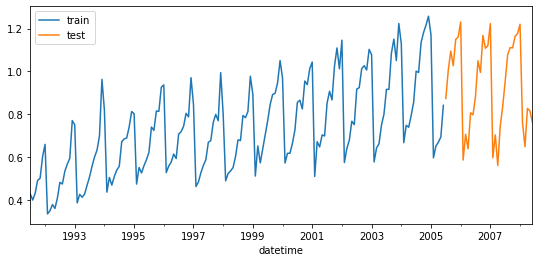

In [103]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Train-test dates
# ==============================================================================
end_train = '2005-06-01 23:59:00'

print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg

In [104]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 3
             )

y = pd.Series(np.arange(10))

print(forecaster.create_train_X_y(y=y)[1].to_markdown())

|    |   y |
|---:|----:|
|  3 |   3 |
|  4 |   4 |
|  5 |   5 |
|  6 |   6 |
|  7 |   7 |
|  8 |   8 |
|  9 |   9 |


In [105]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 3
             )

forecaster.fit(y=data.loc[:end_train])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Window size: 3 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-21 19:31:50 
Last fit date: 2022-06-21 19:31:50 
Skforecast version: 0.5.dev1 

2005-07-01    0.858737
2005-08-01    0.876662
2005-09-01    0.947029
Freq: MS, Name: pred, dtype: float64
Test error (mse): 0.047845770593691536


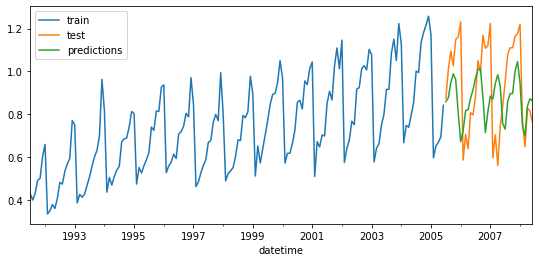

In [106]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
print(predictions.head(3))

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data.loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [109]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 10
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(data.loc[:end_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

results_grid

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:07<00:00,  2.56s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.015161925563451037



,lags,params,metric,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.015162,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.015559,15,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 50}",0.016284,15,50
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.018412,10,50
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.018674,5,50
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.018912,5,100
14,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.037743,10,50
17,"[1, 2, 3, 20]","{'max_depth': 15, 'n_estimators': 100}",0.043362,15,100
13,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.045687,5,100
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.047272,10,50


In [110]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data,
                                    initial_train_size = len(data.loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = False
                               )

print(f"Backtest error: {metric}")

Backtest error: 0.015161925563451037


### ForecasterAutoregMultiSeries

Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


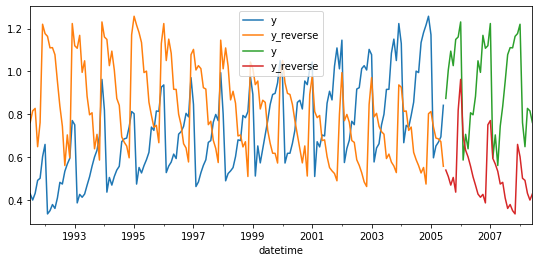

In [111]:
series = pd.DataFrame(data)
series['y_reverse'] = list(series.y)[::-1]
series.head(3)

# Train-test dates
# ==============================================================================
end_train = '2005-06-01 23:59:00'

print(f"Train dates : {series.index.min()} --- {series.loc[:end_train].index.max()}  (n={len(series.loc[:end_train])})")
print(f"Test dates  : {series.loc[end_train:].index.min()} --- {series.index.max()}  (n={len(series.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
series.loc[:end_train].plot(ax=ax, label='train')
series.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

In [112]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 6
             )

forecaster.fit(series=series.loc[:end_train, ])
forecaster

ForecasterAutoregMultiSeries 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-21 19:32:31 
Last fit date: 2022-06-21 19:32:31 
Skforecast version: 0.5.dev1 

2005-07-01    0.850413
2005-08-01    0.839125
2005-09-01    0.896212
Freq: MS, Name: pred, dtype: float64
Test error (mse): 0.07994915989343487


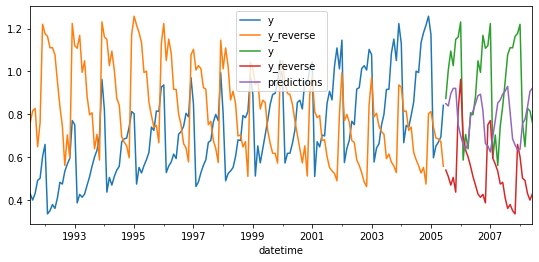

In [114]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(series.loc[end_train:]),
                                 level='y')
print(predictions.head(3))

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
series.loc[:end_train].plot(ax=ax, label='train')
series.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = series.loc[end_train:, 'y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [115]:
steps = 10
forecaster = ForecasterAutoregMultiSeries(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

param_grid = list(ParameterGrid(param_grid))

results_grid = _evaluate_grid_hyperparameters_multiseries(
                        forecaster  = forecaster,
                        series      = series,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        levels_list = ['y'],
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(series.loc[:end_train, ]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

results_grid

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:08<00:00,  2.82s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.014695253840809004
  Levels: ['y'] 
  Levels weights: {'y': 1.0} 



,levels,lags,params,metric,max_depth,n_estimators
9,[y],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.014695,10,100
11,[y],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.014785,15,100
8,[y],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.016110,10,50
10,[y],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 50}",0.016267,15,50
7,[y],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.019048,5,100
6,[y],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.019101,5,50
5,[y],"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 100}",0.040554,15,100
16,[y],"[1, 2, 3, 20]","{'max_depth': 15, 'n_estimators': 50}",0.042731,15,50
15,[y],"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.043301,10,100
17,[y],"[1, 2, 3, 20]","{'max_depth': 15, 'n_estimators': 100}",0.046339,15,100


In [117]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = series,
                                    level      = 'y',
                                    initial_train_size = len(series.loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = False
                               )

print(f"Backtest error: {metric}")

Backtest error: 0.014695253840809004


## Example Product Sales

https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/

In [118]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [120]:
data = pd.read_csv(r'C:\Users\jaesc2\Downloads\Sales_Transactions_Dataset_Weekly.csv')
data = data.filter(regex=r'Product|W')
items = ['P1', 'P2', 'P3', 'P4']
data = data[data['Product_Code'].isin(items)]
data = data.set_index('Product_Code')
data = data.T
data = data.reset_index()
data['Week'] = data['index'].str.extract('(\d+)', expand=False).astype(int)
data = data.rename_axis(None, axis=1)
data = data.drop(columns=['index'])
data.index = pd.date_range(start='2022-01-01', periods=52, freq='1W')
data

,P1,P2,P3,P4,Week
2022-01-02,11,7,7,12,0
2022-01-09,12,6,11,8,1
2022-01-16,10,3,8,13,2
2022-01-23,8,2,9,5,3
2022-01-30,13,7,10,9,4
2022-02-06,12,1,8,6,5
2022-02-13,14,6,7,9,6
2022-02-20,21,3,13,13,7
2022-02-27,6,3,12,13,8
2022-03-06,14,3,6,11,9


Train dates : 2022-01-02 00:00:00 --- 2022-09-25 00:00:00  (n=39)
Test dates  : 2022-10-02 00:00:00 --- 2022-12-25 00:00:00  (n=13)


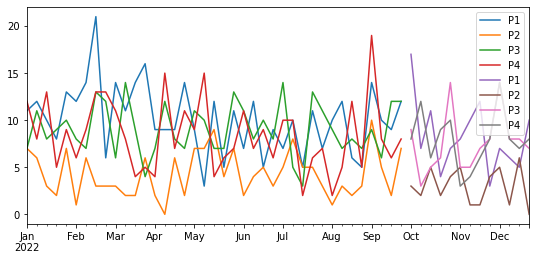

In [121]:
# Train-test dates
# ==============================================================================
end_train = '2022-09-30 23:59:00'

print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data[items].loc[:end_train].plot(ax=ax, label='train')
data[items].loc[end_train:].plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg P1

In [72]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 4
             )

forecaster.fit(y=data.loc[:end_train, 'P1'], exog=data.loc[:end_train, 'Week'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4] 
Window size: 4 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Week 
Training range: [Timestamp('2022-01-02 00:00:00'), Timestamp('2022-09-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-08 18:07:56 
Last fit date: 2022-06-08 18:07:56 
Skforecast version: 0.5.dev1 

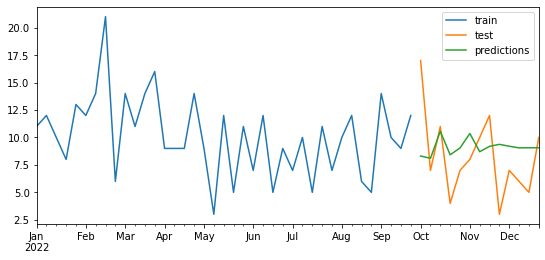

In [73]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data.loc[end_train:]), exog=data.loc[end_train:, 'Week'])
predictions.head(3)

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data['P1'].loc[:end_train].plot(ax=ax, label='train')
data['P1'].loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [74]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data['P1'].loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 14.450769230769229


In [75]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['P1'],
                                    initial_train_size = len(data['P1'].loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 3,
                                    exog       = data['Week'],
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = False
                               )

print(f"Backtest error: {metric}")

Backtest error: 17.774153846153848


In [76]:
# Grid search hyperparameter and lags
# ==============================================================================

# Regressor hyperparameters
param_grid = {'n_estimators': [10, 20],
              'max_depth': [5, 7, 10]}

# Lags used as predictors
lags_grid = [3, 4, 5]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data['P1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 3,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(data['P1'].loc[:end_train]),
                        fixed_train_size   = False,
                        exog       = data['Week'],
                        return_best = False,
                        verbose     = False
               )

results_grid

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


,lags,params,metric,max_depth,n_estimators
13,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 20}",17.929058,5,20
8,"[1, 2, 3, 4]","{'max_depth': 7, 'n_estimators': 10}",18.227009,7,10
11,"[1, 2, 3, 4]","{'max_depth': 10, 'n_estimators': 20}",18.253462,10,20
14,"[1, 2, 3, 4, 5]","{'max_depth': 7, 'n_estimators': 10}",18.264666,7,10
9,"[1, 2, 3, 4]","{'max_depth': 7, 'n_estimators': 20}",18.498871,7,20
6,"[1, 2, 3, 4]","{'max_depth': 5, 'n_estimators': 10}",18.499416,5,10
7,"[1, 2, 3, 4]","{'max_depth': 5, 'n_estimators': 20}",18.598506,5,20
12,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 10}",18.600161,5,10
10,"[1, 2, 3, 4]","{'max_depth': 10, 'n_estimators': 10}",18.813077,10,10
15,"[1, 2, 3, 4, 5]","{'max_depth': 7, 'n_estimators': 20}",19.295880,7,20


### ForecasterAutoregMultiSeries

In [127]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 4
             )

forecaster.fit(series=data.loc[:end_train, items], exog=data.loc[:end_train, 'Week'])
forecaster

ForecasterAutoregMultiSeries 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4] 
Window size: 4 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Week 
Training range: [Timestamp('2022-01-02 00:00:00'), Timestamp('2022-09-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-21 19:40:29 
Last fit date: 2022-06-21 19:40:29 
Skforecast version: 0.5.dev1 

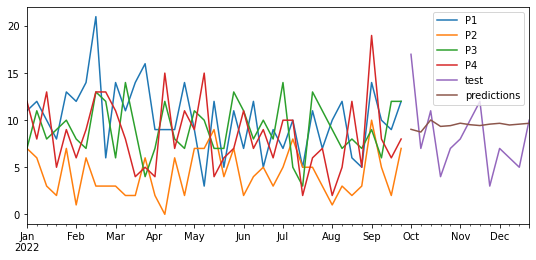

In [128]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data.loc[end_train:]),
                                 level='P1',
                                 exog=data.loc[end_train:, 'Week'])
predictions.head(3)

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train, items].plot(ax=ax, label='train')
data.loc[end_train:, 'P1'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [129]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data['P1'].loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 15.017638461538464


In [137]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = data[items],
                                    level      = 'P1',
                                    initial_train_size = len(data['P1'].loc[:end_train]),
                                    fixed_train_size   = True,
                                    steps      = 3,
                                    exog       = data['Week'],
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    interval   = [10, 90],
                                    n_boot     = 100,
                                    verbose    = False
                               )

print(f"Backtest error: {metric}")
predictions_backtest

Backtest error: 17.0363


,pred,lower_bound,upper_bound
2022-10-02,9.03,7.805,10.920
2022-10-09,8.74,7.280,10.182
2022-10-16,10.02,8.306,11.493
2022-10-23,10.09,8.870,12.110
2022-10-30,13.39,12.038,15.390
2022-11-06,8.20,6.351,11.300
2022-11-13,9.31,7.450,10.790
2022-11-20,7.09,5.220,9.320
2022-11-27,8.40,6.579,10.030
2022-12-04,6.22,4.860,8.120


In [85]:
# Lags used as predictors
lags_grid = [3, 4, 5]

# Regressor hyperparameters
param_grid = {'n_estimators': [10, 20],
              'max_depth': [5, 7, 10]}

param_grid = list(ParameterGrid(param_grid))

results_grid = _evaluate_grid_hyperparameters_multiseries(
                        forecaster  = forecaster,
                        series      = data[items],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 3,
                        levels_list = None,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(data['P1'].loc[:end_train]),
                        fixed_train_size   = False,
                        exog        = data['Week'],
                        return_best = True,
                        verbose     = False
               )

results_grid

Number of models compared: 72.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:07<00:00,  2.41s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 9.996191733262911
  Levels: ['P1', 'P2', 'P3', 'P4'] 
  Levels weights: {'P1': 0.25, 'P2': 0.25, 'P3': 0.25, 'P4': 0.25} 



,levels,lags,params,metric,max_depth,n_estimators
17,"[P1, P2, P3, P4]","[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 20}",9.996192,10,20
15,"[P1, P2, P3, P4]","[1, 2, 3, 4, 5]","{'max_depth': 7, 'n_estimators': 20}",10.389692,7,20
6,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 5, 'n_estimators': 10}",10.432557,5,10
13,"[P1, P2, P3, P4]","[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 20}",10.544319,5,20
1,"[P1, P2, P3, P4]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 20}",10.726509,5,20
7,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 5, 'n_estimators': 20}",10.930787,5,20
9,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 7, 'n_estimators': 20}",10.948408,7,20
8,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 7, 'n_estimators': 10}",11.008187,7,10
10,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 10, 'n_estimators': 10}",11.063157,10,10
11,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 10, 'n_estimators': 20}",11.301189,10,20


In [ ]:
12.94 = m_b_p1 *0.25 + m_b_p2 *0.25 + m_b_p3 *0.25 + m_b_p4 *0.25

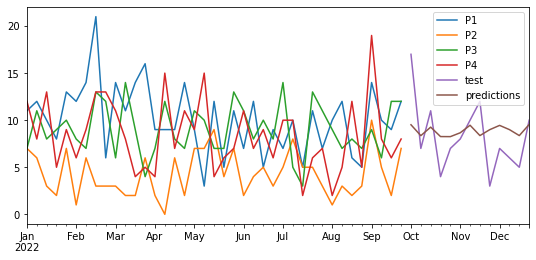

In [87]:
# Predict
# ==============================================================================
forecaster.fit(series=data.loc[:end_train, items], exog=data.loc[:end_train, 'Week'])
predictions = forecaster.predict(steps=len(data.loc[end_train:]),
                                 level='P1',
                                 exog=data.loc[end_train:, 'Week'])
predictions.head(3)

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train, items].plot(ax=ax, label='train')
data.loc[end_train:, 'P1'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Example AirQuality

Web con muchos datasets:
https://archive.ics.uci.edu/ml/datasets.php?format=&task=&att=&area=&numAtt=&numIns=&type=ts&sort=taskUp&view=table

Dataset:
https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

In [126]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [21]:
data = pd.read_csv(r'C:\Users\jaesc2\Downloads\PRSA_Data_Guanyuan_20130301-20170228.csv')
data['date'] = pd.to_datetime(data[["year", "month", "day", 'hour']])
data = data.drop(columns=['No', 'station', "year", 'month', "day", 'hour', 'wd'])
data = data.fillna(method='ffill')
data = data.set_index('date')
data = data.asfreq('1H')
data = data.sort_index()
data = data.resample(rule='D', closed='left', label ='left').agg({
            'PM2.5':'sum','PM10':'sum','SO2':'sum',
            'NO2':'sum','CO':'sum','O3':'sum',
            'TEMP':'mean','PRES':'mean','DEWP':'mean',
            'RAIN': 'mean', 'WSPM': 'mean'
             })

data['month'] = data.index.month
data

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,month
date,,,,,,,,,,,,
2013-03-01,181.0,280.0,204.0,684.0,9600.0,1516.0,1.391667,1026.875000,-18.745833,0.0,3.254167,3
2013-03-02,633.0,837.0,674.0,1495.0,20198.0,844.0,0.616667,1026.850000,-15.937500,0.0,1.479167,3
2013-03-03,1956.0,2858.0,1661.0,2315.0,47195.0,396.0,5.566667,1014.608333,-12.316667,0.0,1.658333,3
2013-03-04,438.0,1007.0,485.0,1232.0,15000.0,1308.0,9.962500,1017.650000,-11.683333,0.0,2.404167,3
2013-03-05,3388.0,3929.0,2001.0,3234.0,59594.0,1891.0,6.291667,1010.900000,-7.525000,0.0,1.129167,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,719.0,1031.0,206.0,1278.0,17500.0,812.0,5.166667,1021.012500,-11.141667,0.0,1.595833,2
2017-02-25,236.0,471.0,89.0,799.0,9600.0,1277.0,7.245833,1018.812500,-10.754167,0.0,1.825000,2
2017-02-26,681.0,1092.0,264.0,1514.0,18700.0,707.0,7.208333,1020.337500,-8.258333,0.0,1.566667,2


Train dates : 2013-03-01 00:00:00 --- 2016-05-31 00:00:00  (n=1188)
Test dates  : 2016-06-01 00:00:00 --- 2017-02-28 00:00:00  (n=273)
% test: 0.2297979797979798


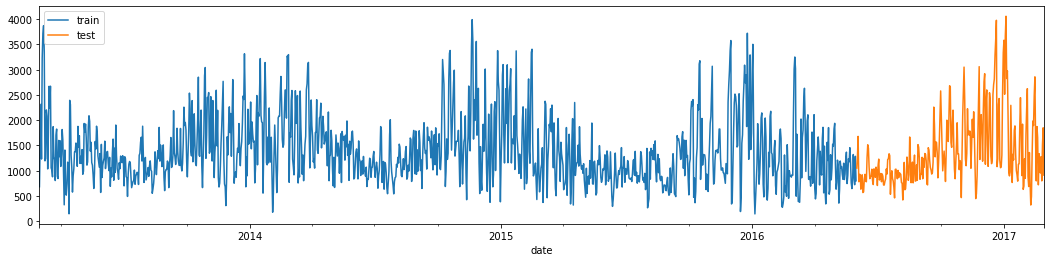

In [32]:
# Train-test dates
# ==============================================================================
level = 'NO2'

end_train = '2016-05-31 23:59:00'

print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")
print(f'% test: {len(data.loc[end_train:])/len(data.loc[:end_train])}')

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(18, 4))
data[level].loc[:end_train].plot(ax=ax, label='train')
data[level].loc[end_train:].plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg TEMP

In [16]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=123, n_jobs=-1),
                    lags      = 7
             )

forecaster.fit(y=data.loc[:end_train, level], exog=data.loc[:end_train, 'CO', 'month'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Window size: 14 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2016-05-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-09 14:23:53 
Last fit date: 2022-06-09 14:23:54 
Skforecast version: 0.5.dev1 

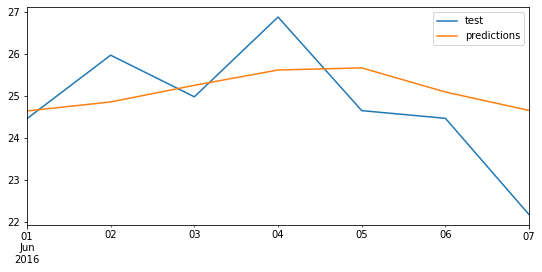

In [19]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=7)
predictions.head(3)

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data[level].loc[predictions.index].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [24]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data[level].loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

TypeError: can only concatenate str (not "int") to str

In [26]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data[level],
                                    initial_train_size = len(data[level].loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 3,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = False
                               )

print(f"Backtest error: {metric}")

Forecaster will be fit 91 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Backtest error: 5.955522906781658


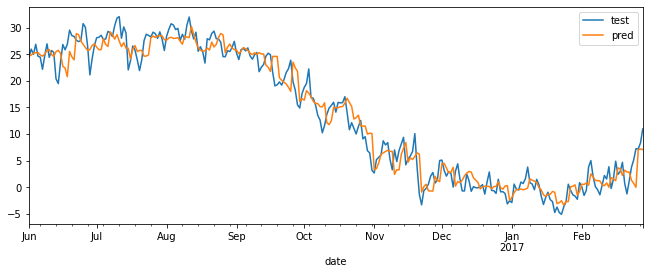

In [28]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data[level].loc[end_train:].plot(ax=ax, label='test')
predictions_backtest['pred'].plot(ax=ax, label='pred')
ax.legend();

In [30]:
# Grid search hyperparameter and lags
# ==============================================================================

# Regressor hyperparameters
param_grid = {'n_estimators': [300, 500],
              'max_depth': [5, 10]
             }

# Lags used as predictors
lags_grid = [7, 14]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data[level],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 7,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(data[level].loc[:end_train]),
                        fixed_train_size   = True,
                        return_best = False,
                        verbose     = False
               )

results_grid

Number of models compared: 8.


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [04:35<00:00, 137.76s/it]


,lags,params,metric,max_depth,n_estimators
1,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 5, 'n_estimators': 500}",8.702637,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 5, 'n_estimators': 500}",8.714303,5,500
0,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 5, 'n_estimators': 300}",8.735642,5,300
3,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 10, 'n_estimators': 500}",8.784227,10,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 5, 'n_estimators': 300}",8.787482,5,300
2,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 10, 'n_estimators': 300}",8.831389,10,300
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 500}",8.975597,10,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 300}",9.049124,10,300


## Example Products Sales Pycaret

https://moez-62905.medium.com/multiple-time-series-forecasting-in-python-fab0a8a1afdb

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries.model_selection_multiseries import grid_search_forecaster_multiseries

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\jaesc2\Miniconda3\envs\food_digital\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Train dates      : 2013-01-01 00:00:00 --- 2016-12-31 00:00:00  (n=1461)
Validation dates : 2017-01-01 00:00:00 --- 2017-12-31 00:00:00  (n=365)


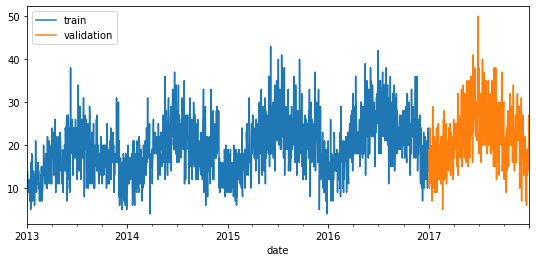

,1,10,11,12,13,14,15,16,17,18,...,5,50,6,7,8,9,month,year,day_of_week,day_of_year
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,37,37,33,37,22,42,14,13,38,...,11,30,31,25,33,18,1,2013,1,1
2013-01-02,11,34,43,35,31,35,33,11,18,51,...,6,32,36,23,37,23,1,2013,2,2
2013-01-03,14,32,34,41,50,26,45,12,15,42,...,8,25,18,34,38,25,1,2013,3,3
2013-01-04,13,45,52,45,45,32,39,15,19,50,...,9,32,19,36,54,22,1,2013,4,4


In [3]:
# read the csv file
data_raw = pd.read_csv(r'C:\Users\jaesc2\Downloads\train.csv')

# Filter store 1
data = data_raw[data_raw['store'] == 1].copy()
data = data.drop(['store'], axis=1)
data['date'] = pd.to_datetime(data['date'])
data['item'] = data['item'].astype(str)

# Pivot_table, 1 item per column
data = pd.pivot_table(data, values='sales', index=['date'], columns=['item'], aggfunc=np.sum)
data.columns.name = None

# datetime index
data = data.asfreq('1D')
data = data.sort_index()

# extract features from date
data['month'] = [i.month for i in data.index]
data['year'] = [i.year for i in data.index]
data['day_of_week'] = [i.dayofweek for i in data.index]
data['day_of_year'] = [i.dayofyear for i in data.index]

# Train-validation dates
# ==============================================================================
end_train = '2016-12-31 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train, '1'].plot(ax=ax, label='train')
data.loc[end_train:, '1'].plot(ax=ax, label='validation')
ax.legend()
plt.show()

display(data.head(4))

### Autocorrelation plots

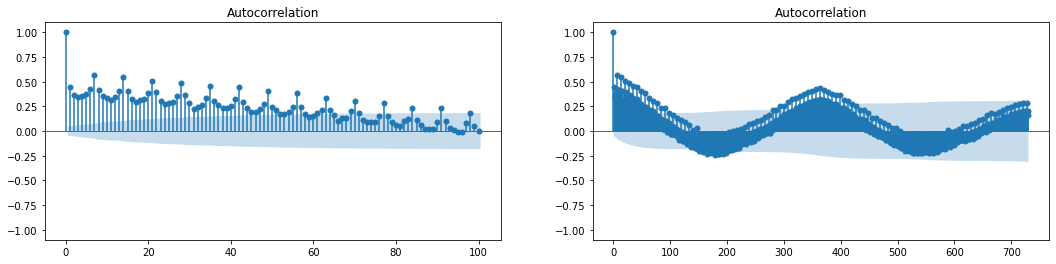

In [68]:
# Autocorrelation plot
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data['1'], ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data['1'], ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

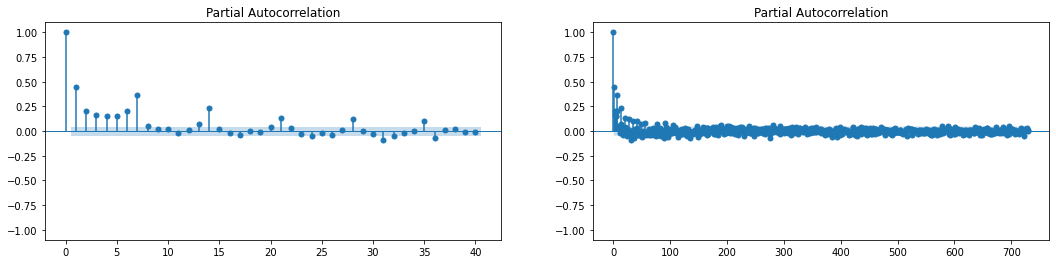

In [71]:
# Partial autocorrelation plot
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_pacf(data['1'], ax=axes[0], lags=40, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(data['1'], ax=axes[1], lags=730, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

### ForecasterAutoreg Product 1

In [66]:
exog = ['month', 'year', 'day_of_week', 'day_of_year']

In [67]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = [1, 2, 3, 7, 14]
             )

forecaster.fit(y=data.loc[:end_train, '1'], exog=data.loc[:end_train, exog])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  7 14] 
Window size: 14 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['month', 'year', 'day_of_week', 'day_of_year'] 
Training range: [Timestamp('2013-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-21 19:10:00 
Last fit date: 2022-06-21 19:10:00 
Skforecast version: 0.5.dev1 

In [68]:
forecaster.in_sample_residuals

date
2013-08-21   -0.18
2015-04-02   -0.23
2015-11-29    0.75
2016-05-01    2.15
2015-10-17   -1.33
              ... 
2015-01-10    0.58
2015-03-27   -3.12
2015-07-20    0.33
2013-06-06   -3.60
2015-11-27    4.06
Name: in_sample_residuals, Length: 1000, dtype: float64

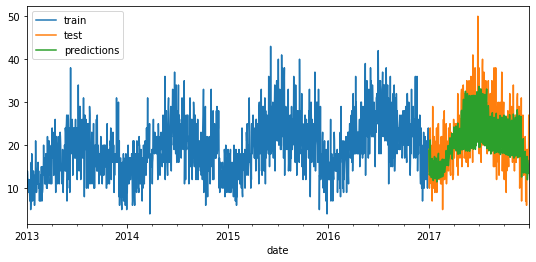

In [75]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data.loc[end_train:]), exog=data.loc[end_train:, exog])
predictions.head(3)

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data['1'].loc[:end_train].plot(ax=ax, label='train')
data['1'].loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

#### Prediction error

In [76]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data['1'].loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 27.22646712328767


#### Backtesting

In [ ]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LGBMRegressor(),
                 lags = 7
             )

In [77]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['1'],
                                    initial_train_size = len(data['1'].loc[:end_train]),
                                    fixed_train_size   = True,
                                    steps      = 7,
                                    exog       = data[exog],
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1461
Number of observations used for backtesting: 365
    Number of folds: 53
    Number of steps per fold: 7
    Last fold only includes 1 observations.

Data partition in fold: 0
    Training:   2013-01-01 00:00:00 -- 2016-12-31 00:00:00  (n=1461)
    Validation: 2017-01-01 00:00:00 -- 2017-01-07 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2013-01-08 00:00:00 -- 2017-01-07 00:00:00  (n=1461)
    Validation: 2017-01-08 00:00:00 -- 2017-01-14 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2013-01-15 00:00:00 -- 2017-01-14 00:00:00  (n=1461)
    Validation: 2017-01-15 00:00:00 -- 2017-01-21 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2013-01-22 00:00:00 -- 2017-01-21 00:00:00  (n=1461)
    Validation: 2017-01-22 00:00:00 -- 2017-01-28 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2013-01-29 00:00:00 -- 2017-01-28 00:00

Backtest error: 24.912978082191785


#### Grid search

In [79]:
# Grid search hyperparameter and lags
# ==============================================================================

# Regressor hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags used as predictors
lags_grid = [7, 14, [1, 2, 3, 7, 14]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.loc[:end_train, '1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 7,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data.loc[:end_train, '1'])*0.7),
                        fixed_train_size   = True,
                        exog        = data.loc[:end_train, exog],
                        return_best = True,
                        verbose     = False
               )

results_grid

Number of models compared: 18.


loop param_grid:   0%|                                              | 0/6 [00:00<?, ?it/s]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  17%|██████▎                               | 1/6 [00:10<00:51, 10.26s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  33%|████████████▋                         | 2/6 [01:00<02:14, 33.70s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  50%|███████████████████                   | 3/6 [01:13<01:12, 24.33s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  67%|█████████████████████████▎            | 4/6 [02:16<01:19, 39.64s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  83%|███████████████████████████████▋      | 5/6 [02:36<00:32, 32.33s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:   0%|                                              | 0/6 [00:00<?, ?it/s]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  17%|██████▎                               | 1/6 [00:12<01:02, 12.52s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  33%|████████████▋                         | 2/6 [01:12<02:42, 40.54s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  50%|███████████████████                   | 3/6 [01:29<01:29, 29.71s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  67%|█████████████████████████▎            | 4/6 [02:50<01:39, 49.83s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  83%|███████████████████████████████▋      | 5/6 [03:16<00:41, 41.47s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:   0%|                                              | 0/6 [00:00<?, ?it/s]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  17%|██████▎                               | 1/6 [00:09<00:49,  9.88s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  33%|████████████▋                         | 2/6 [00:57<02:07, 31.98s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  50%|███████████████████                   | 3/6 [01:09<01:08, 22.71s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  67%|█████████████████████████▎            | 4/6 [02:05<01:12, 36.21s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop param_grid:  83%|███████████████████████████████▋      | 5/6 [02:23<00:29, 29.36s/it]

Forecaster will be fit 63 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 




loop lags_grid: 100%|██████████████████████████████████████| 3/3 [13:22<00:00, 267.48s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 23.830573621233



,lags,params,metric,max_depth,n_estimators
5,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 10, 'n_estimators': 500}",23.830574,10,500
4,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 10, 'n_estimators': 100}",24.110134,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 500}",24.142462,10,500
17,"[1, 2, 3, 7, 14]","{'max_depth': 10, 'n_estimators': 500}",24.284685,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 5, 'n_estimators': 500}",24.433051,5,500
15,"[1, 2, 3, 7, 14]","{'max_depth': 5, 'n_estimators': 500}",24.475926,5,500
16,"[1, 2, 3, 7, 14]","{'max_depth': 10, 'n_estimators': 100}",24.497291,10,100
3,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 5, 'n_estimators': 500}",24.571383,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 5, 'n_estimators': 100}",24.585386,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 100}",24.633302,10,100


In [86]:
pd.DataFrame(np.array([[np.array([1, 2, 3, 4, 5, 6, 7]),
        {'max_depth': 10, 'n_estimators': 500}, 23.830573621233, 10, 500],
       [np.array([1, 2, 3, 4, 5, 6, 7]),
        {'max_depth': 10, 'n_estimators': 100}, 24.11013416886274, 10,
        100],
       [np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
        {'max_depth': 10, 'n_estimators': 500}, 24.142461781020355, 10,
        500],
       [np.array([ 1,  2,  3,  7, 14]),
        {'max_depth': 10, 'n_estimators': 500}, 24.284684881060105, 10,
        500],
       [np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
        {'max_depth': 5, 'n_estimators': 500}, 24.43305095735186, 5, 500],
       [np.array([ 1,  2,  3,  7, 14]),
        {'max_depth': 5, 'n_estimators': 500}, 24.47592565094498, 5, 500],
       [np.array([ 1,  2,  3,  7, 14]),
        {'max_depth': 10, 'n_estimators': 100}, 24.497291005989357, 10,
        100],
       [np.array([1, 2, 3, 4, 5, 6, 7]),
        {'max_depth': 5, 'n_estimators': 500}, 24.571382884640418, 5,
        500],
       [np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
        {'max_depth': 5, 'n_estimators': 100}, 24.58538585250853, 5, 100],
       [np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
        {'max_depth': 10, 'n_estimators': 100}, 24.633302265796207, 10,
        100],
       [np.array([1, 2, 3, 4, 5, 6, 7]),
        {'max_depth': 5, 'n_estimators': 100}, 24.63665446582595, 5, 100],
       [np.array([ 1,  2,  3,  7, 14]),
        {'max_depth': 5, 'n_estimators': 100}, 24.696350725182135, 5,
        100],
       [np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
        {'max_depth': 3, 'n_estimators': 100}, 27.068923548522278, 3,
        100],
       [np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
        {'max_depth': 3, 'n_estimators': 500}, 27.094612363207872, 3,
        500],
       [np.array([ 1,  2,  3,  7, 14]),
        {'max_depth': 3, 'n_estimators': 500}, 27.294643755132395, 3,
        500],
       [np.array([ 1,  2,  3,  7, 14]),
        {'max_depth': 3, 'n_estimators': 100}, 27.436146789296934, 3,
        100],
       [np.array([1, 2, 3, 4, 5, 6, 7]),
        {'max_depth': 3, 'n_estimators': 500}, 27.809287514027567, 3,
        500],
       [np.array([1, 2, 3, 4, 5, 6, 7]),
        {'max_depth': 3, 'n_estimators': 100}, 27.90044492276429, 3, 100]],
      dtype=object))

,0,1,2,3,4
0,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 10, 'n_estimators': 500}",23.830574,10,500
1,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 10, 'n_estimators': 100}",24.110134,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 500}",24.142462,10,500
3,"[1, 2, 3, 7, 14]","{'max_depth': 10, 'n_estimators': 500}",24.284685,10,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 5, 'n_estimators': 500}",24.433051,5,500
5,"[1, 2, 3, 7, 14]","{'max_depth': 5, 'n_estimators': 500}",24.475926,5,500
6,"[1, 2, 3, 7, 14]","{'max_depth': 10, 'n_estimators': 100}",24.497291,10,100
7,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 5, 'n_estimators': 500}",24.571383,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 5, 'n_estimators': 100}",24.585386,5,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 100}",24.633302,10,100


In [ ]:
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123,
                                                      n_estimators=500,
                                                      max_depth=10),
                    lags      = 7
             )

forecaster.fit(y=data.loc[:end_train, '1'], exog=data.loc[:end_train, exog])
forecaster

#### Backtesting Opt

In [80]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['1'],
                                    initial_train_size = len(data['1'].loc[:end_train]),
                                    fixed_train_size   = True,
                                    steps      = 7,
                                    exog       = data[exog],
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1461
Number of observations used for backtesting: 365
    Number of folds: 53
    Number of steps per fold: 7
    Last fold only includes 1 observations.

Data partition in fold: 0
    Training:   2013-01-01 00:00:00 -- 2016-12-31 00:00:00  (n=1461)
    Validation: 2017-01-01 00:00:00 -- 2017-01-07 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2013-01-08 00:00:00 -- 2017-01-07 00:00:00  (n=1461)
    Validation: 2017-01-08 00:00:00 -- 2017-01-14 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2013-01-15 00:00:00 -- 2017-01-14 00:00:00  (n=1461)
    Validation: 2017-01-15 00:00:00 -- 2017-01-21 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2013-01-22 00:00:00 -- 2017-01-21 00:00:00  (n=1461)
    Validation: 2017-01-22 00:00:00 -- 2017-01-28 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2013-01-29 00:00:00 -- 2017-01-28 00:00

Backtest error: 25.664211399555892


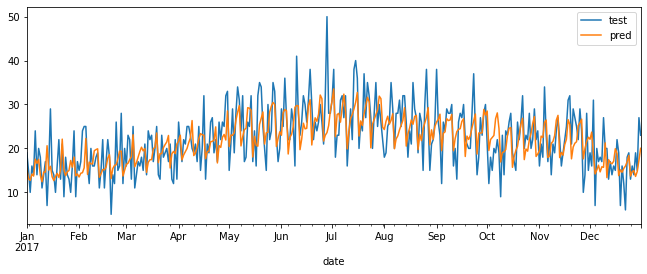

In [81]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data['1'].loc[end_train:].plot(ax=ax, label='test')
predictions_backtest['pred'].plot(ax=ax, label='pred')
ax.legend();

### ForecasterAutoregMultiSeries

In [4]:
exog = ['month', 'year', 'day_of_week', 'day_of_year']

series_cols = list(range(1,51))
series_cols = [str(x) for x in series_cols]
series_cols[:3]

['1', '2', '3']

In [64]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = [1, 2, 3, 7, 14]
             )

forecaster.fit(series=data.loc[:end_train, series_cols], exog=data.loc[:end_train, exog],
               store_in_sample_residuals=True)
forecaster

C:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:434: UserWarning: Due to the high number of levels, the size of residues stored in `in_sample_residuals` for each level is less than 50. Consider setting other residues using `set_out_sample_residuals` before using `predict_interval`.
  warnings.warn(


ForecasterAutoregMultiSeries 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  7 14] 
Window size: 14 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['month', 'year', 'day_of_week', 'day_of_year'] 
Training range: [Timestamp('2013-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-21 19:08:16 
Last fit date: 2022-06-21 19:08:50 
Skforecast version: 0.5.dev1 

In [70]:
forecaster.in_sample_residuals

{'1': array([None], dtype=object), '2': array([None], dtype=object)}

In [101]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                           '2': pd.Series(np.arange(10))
                          })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series, store_in_sample_residuals=False)

# with pytest.raises(Exception):
forecaster.predict_interval(steps=1, level='1', in_sample_residuals=True)

Exception: `forecaster.in_sample_residuals[level]` contains `None` values. Try using `fit` method with `in_sample_residuals=True` or set in `predict_interval` method `in_sample_residuals=False` and use `out_sample_residuals` (see `set_out_sample_residuals()`).

In [100]:
if True and (forecaster.in_sample_residuals['1'] == None).any():
    raise Exception(
        ('`forecaster.in_sample_residuals[level]` is `None`. Use `fit` ' 
         'method with `in_sample_residuals=True` or set in `predict_interval` '
         'method `in_sample_residuals=False` and use `out_sample_residuals` '
         '(see `set_out_sample_residuals()`).')
    )

Exception: `forecaster.in_sample_residuals[level]` is `None`. Use `fit` method with `in_sample_residuals=True` or set in `predict_interval` method `in_sample_residuals=False` and use `out_sample_residuals` (see `set_out_sample_residuals()`).

In [95]:
dict_in_sample_residuals = {'1': np.array([None, 2]),
                            '2': np.array([1,2,43])}

In [97]:
(dict_in_sample_residuals['1'] == None).any()

True

#### Prediction error

2017-01-01    20.55
2017-01-02    15.63
2017-01-03    14.21
Freq: D, Name: pred, dtype: float64

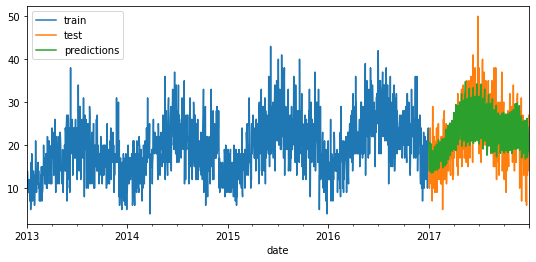

In [29]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data.loc[end_train:]),
                                 level='1',
                                 exog=data.loc[end_train:, exog])
display(predictions.head(3))

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train, '1'].plot(ax=ax, label='train')
data.loc[end_train:, '1'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [30]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data['1'].loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 27.553178630136983


#### Backtesting

In [104]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = data[series_cols],
                                    level      = '1',
                                    initial_train_size = len(data.loc[:end_train]),
                                    fixed_train_size   = True,
                                    steps      = 7,
                                    exog       = data[exog],
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1461
Number of observations used for backtesting: 365
    Number of folds: 53
    Number of steps per fold: 7
    Last fold only includes 1 observations.

Data partition in fold: 0
    Training:   2013-01-01 00:00:00 -- 2016-12-31 00:00:00  (n=1461)
    Validation: 2017-01-01 00:00:00 -- 2017-01-07 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2013-01-08 00:00:00 -- 2017-01-07 00:00:00  (n=1461)
    Validation: 2017-01-08 00:00:00 -- 2017-01-14 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2013-01-15 00:00:00 -- 2017-01-14 00:00:00  (n=1461)
    Validation: 2017-01-15 00:00:00 -- 2017-01-21 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2013-01-22 00:00:00 -- 2017-01-21 00:00:00  (n=1461)
    Validation: 2017-01-22 00:00:00 -- 2017-01-28 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2013-01-29 00:00:00 -- 2017-01-28 00:00

C:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:428: UserWarning: Due to the high number of levels, the size of residues stored in `in_sample_residuals` for each level is less than 50. Consider setting other residues using `set_out_sample_residuals` before using `predict_interval`.
  warnings.warn(
C:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:428: UserWarning: Due to the high number of levels, the size of residues stored in `in_sample_residuals` for each level is less than 50. Consider setting other residues using `set_out_sample_residuals` before using `predict_interval`.
  warnings.warn(
C:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:428: UserWarning: Due to the high number of levels, the size of residues stored in `in_sample_residuals` for each level is less than 50. Consider setting other residues using `se

C:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:428: UserWarning: Due to the high number of levels, the size of residues stored in `in_sample_residuals` for each level is less than 50. Consider setting other residues using `set_out_sample_residuals` before using `predict_interval`.
  warnings.warn(
C:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:428: UserWarning: Due to the high number of levels, the size of residues stored in `in_sample_residuals` for each level is less than 50. Consider setting other residues using `set_out_sample_residuals` before using `predict_interval`.
  warnings.warn(
C:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:428: UserWarning: Due to the high number of levels, the size of residues stored in `in_sample_residuals` for each level is less than 50. Consider setting other residues using `se

KeyboardInterrupt: 

In [ ]:
print(f"Backtest error: {metric}")

#### Grid Search

In [ ]:
# Lags used as predictors
lags_grid = [7, 14, [1, 2, 3, 7, 14]]

# Regressor hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster_multiseries(
                        forecaster     = forecaster,
                        series         = data.loc[:end_train, series],
                        param_grid     = param_grid,
                        lags_grid      = lags_grid,
                        steps          = 7,
                        levels_list    = ['1'],
                        levels_weights = None,
                        refit          = True,
                        metric         = 'mean_squared_error',
                        initial_train_size = int(len(data.loc[:end_train])*0.7),
                        fixed_train_size   = True,
                        exog           = data.loc[:end_train, exog],
                        return_best    = True,
                        verbose        = False
               )

results_grid

#### Backtesting Opt

In [ ]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = data[series_cols],
                                    level      = '1',
                                    initial_train_size = len(data.loc[:end_train]),
                                    fixed_train_size   = True,
                                    steps      = 7,
                                    exog       = data[exog],
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

In [ ]:
print(f"Backtest error: {metric}")

In [ ]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data['1'].loc[end_train:].plot(ax=ax, label='test')
predictions_backtest['pred'].plot(ax=ax, label='pred')
ax.legend();

## Example hourly electricity demand for Victoria

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

In [5]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12
}
# fig.patch.set_facecolor('#212946')
plt.rcParams.update(dark_style)

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries.model_selection_multiseries import grid_search_forecaster_multiseries

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')
%config Completer.use_jedi = False

In [6]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='D', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean', 'Holiday': 'max'})
data.head()

,Demand,Temperature,Holiday
Time,,,
2012-01-01,82531.745918,21.047727,True
2012-01-02,227778.257304,26.578125,True
2012-01-03,275490.988882,31.751042,True
2012-01-04,258955.329422,24.567708,False
2012-01-05,213792.376946,18.191667,False


In [7]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-9-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Validation dates : 2014-01-01 00:00:00 --- 2014-09-30 00:00:00  (n=273)
Test dates       : 2014-10-01 00:00:00 --- 2014-12-30 00:00:00  (n=91)


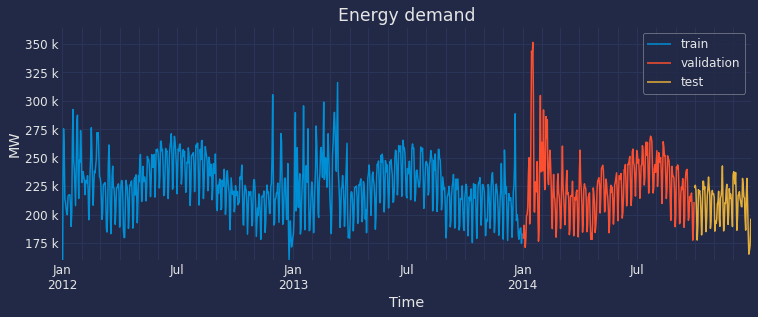

In [8]:
# Plot time serie partition
# ==============================================================================
fig, ax=plt.subplots(figsize=(11, 4))
data_train['Demand'].plot(label='train', ax=ax)
data_val['Demand'].plot(label='validation', ax=ax)
data_test['Demand'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylim(bottom=160_000)
ax.set_ylabel('MW')
ax.set_title('Energy demand')
ax.legend();

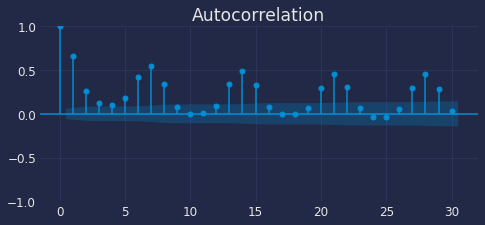

In [9]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data.Demand, ax=ax, lags=30)
plt.show()

### ForecasterAutoreg Energy demand

In [11]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(),
                lags = 7
            )
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor() 
Lags: [1 2 3 4 5 6 7] 
Window size: 7 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-06-29 18:16:29 
Last fit date: None 
Skforecast version: 0.5.dev1 

#### Grid search

In [147]:
# Grid search of hyper-parameters and lags
# ==============================================================================
# Regressor hyper-parameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [7]

results_grid = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = data.loc[:end_validation, 'Demand'],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = 7,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(data_train)),
                            return_best        = True,
                            verbose            = False
                    )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:30<00:00, 30.98s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 411133164.00389796



In [148]:
results_grid

,lags,params,metric,learning_rate,max_depth,n_estimators
5,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",4.111332e+08,0.01,10.0,500.0
1,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",4.124029e+08,0.01,3.0,500.0
3,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",4.230467e+08,0.01,5.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",4.339794e+08,0.10,3.0,100.0
10,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",4.534766e+08,0.10,10.0,100.0
8,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",4.739756e+08,0.10,5.0,100.0
4,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",4.828863e+08,0.01,10.0,100.0
0,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",4.831907e+08,0.01,3.0,100.0
2,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",4.845074e+08,0.01,5.0,100.0
11,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",5.079887e+08,0.10,10.0,500.0


#### Backtesting

In [12]:
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(learning_rate=0.01,
                                          max_depth=10,
                                          n_estimators=500),
                lags = 7
             )

forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(learning_rate=0.01,
                                          max_depth=3,
                                          n_estimators=1000),
                lags = 7
            )

In [13]:
# Backtesting
# ==============================================================================
metric, predictions_autoreg = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = data['Demand'],
                            initial_train_size = len(data_train) + len(data_val),
                            steps      = 7,
                            refit      = True,
                            metric     = 'mean_squared_error',
                            verbose    = False
                        )

print(f"Backtest error: {metric}")
predictions_autoreg.head(4)

Backtest error: 209046702.5552355


,pred
2014-10-01,226921.230654
2014-10-02,229692.996060
2014-10-03,230848.455843
2014-10-04,213775.029643


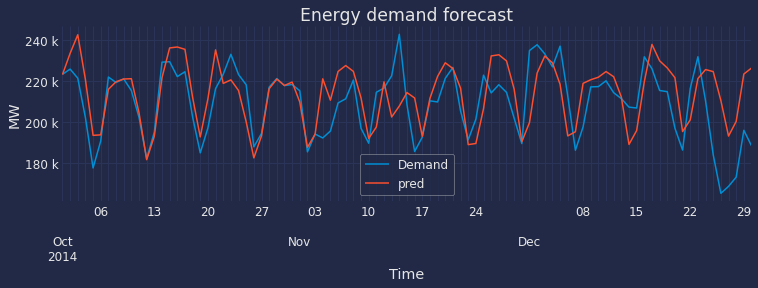

In [169]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(11, 3))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Demand')
predictions_autoreg.plot(ax=ax, label='pred')
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('MW')
ax.set_title('Energy demand forecast')
ax.legend();

### MultiSeries Demand

In [7]:
data.head(2)

,Demand,Temperature,Holiday
Time,,,
2012-01-01,82531.745918,21.047727,True
2012-01-02,227778.257304,26.578125,True


In [8]:
series_cols = ['Demand', 'Temperature']

In [9]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LGBMRegressor(),
                 lags = 7
             )

forecaster

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor() 
Lags: [1 2 3 4 5 6 7] 
Window size: 7 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-06-24 17:55:24 
Last fit date: None 
Skforecast version: 0.5.dev1 

In [25]:
forecaster.fit(series=data[series_cols], store_in_sample_residuals=True)

In [20]:
forecaster.last_window

,Demand,Temperature
Time,,
2014-12-24,210444.465956,18.829167
2014-12-25,184197.155182,18.312500
2014-12-26,165398.200578,16.933333
2014-12-27,168797.125272,16.429167
2014-12-28,173292.325672,18.189583
2014-12-29,196116.228892,24.539583
2014-12-30,188570.258296,17.677083


In [23]:
forecaster.in_sample_residuals

{'Demand': array([None], dtype=object),
 'Temperature': array([None], dtype=object)}

In [13]:
forecaster.create_train_X_y(series=data[series_cols])[0]

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Demand,Temperature
0,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,82531.745918,1.0,0.0
1,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,1.0,0.0
2,200061.614738,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,1.0,0.0
3,216201.836844,200061.614738,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,1.0,0.0
4,217176.907910,216201.836844,200061.614738,200693.270298,205338.714620,211066.426550,213792.376946,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2171,18.312500,18.829167,22.950000,24.031250,18.506250,16.543750,16.520833,0.0,1.0
2172,16.933333,18.312500,18.829167,22.950000,24.031250,18.506250,16.543750,0.0,1.0
2173,16.429167,16.933333,18.312500,18.829167,22.950000,24.031250,18.506250,0.0,1.0
2174,18.189583,16.429167,16.933333,18.312500,18.829167,22.950000,24.031250,0.0,1.0


In [14]:
forecaster.create_train_X_y(series=data[series_cols])[1]

0       200693.270298
1       200061.614738
2       216201.836844
3       217176.907910
4       217517.475010
            ...      
1083        16.933333
1084        16.429167
1085        18.189583
1086        24.539583
1087        17.677083
Name: y, Length: 2176, dtype: float64

In [26]:
forecaster.predict_interval(level='Demand', steps=5)

,pred,lower_bound,upper_bound
2014-12-31,192141.927916,181753.913176,199948.594231
2015-01-01,202674.217871,188241.974999,217791.875788
2015-01-02,203662.810521,187747.791107,215892.401803
2015-01-03,201275.301995,177995.541800,210277.211384
2015-01-04,195809.488372,172554.196065,203494.562378


,Demand,Temperature,Holiday
Time,,,
2014-12-26,165398.200578,16.933333,True
2014-12-27,168797.125272,16.429167,True
2014-12-28,173292.325672,18.189583,False
2014-12-29,196116.228892,24.539583,False
2014-12-30,188570.258296,17.677083,False


#### Grid search

In [158]:
# Grid search of hyper-parameters and lags
# ==============================================================================
# Regressor hyper-parameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [7]

results_grid = grid_search_forecaster_multiseries(
                            forecaster         = forecaster,
                            series             = data.loc[:end_validation, series_cols],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = 7,
                            levels_list        = ['Demand', 'Temperatura'],
                            levels_weights     = None,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(data_train)),
                            return_best        = True,
                            verbose            = False
                    )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:41<00:00, 41.40s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 380219636.4876833
  Levels: ['Demand'] 
  Levels weights: {'Demand': 1.0} 



In [159]:
results_grid

,levels,lags,params,metric,learning_rate,max_depth,n_estimators
6,[Demand],"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",3.802196e+08,0.10,3.0,100.0
1,[Demand],"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",4.026886e+08,0.01,3.0,500.0
5,[Demand],"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",4.125263e+08,0.01,10.0,500.0
3,[Demand],"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",4.137553e+08,0.01,5.0,500.0
10,[Demand],"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",4.467099e+08,0.10,10.0,100.0
8,[Demand],"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",4.479551e+08,0.10,5.0,100.0
7,[Demand],"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",5.144818e+08,0.10,3.0,500.0
9,[Demand],"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",5.561629e+08,0.10,5.0,500.0
11,[Demand],"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",5.725650e+08,0.10,10.0,500.0
0,[Demand],"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",2.994472e+09,0.01,3.0,100.0


#### Backtesting

In [172]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(learning_rate=0.1,
                                          max_depth=3,
                                          n_estimators=100),
                lags = 7
             )

In [173]:
# Backtesting
# ==============================================================================
metric, predictions_multi = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = data[series_cols],
                                    level      = 'Demand',
                                    initial_train_size = len(data_train) + len(data_val),
                                    fixed_train_size   = True,
                                    steps      = 7,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = False
                               )

print(f"Backtest error: {metric}")
predictions_multi.head(4)

Backtest error: 202519854.25862473


,pred
2014-10-01,222687.225943
2014-10-02,226244.881610
2014-10-03,226342.801857
2014-10-04,208002.240375


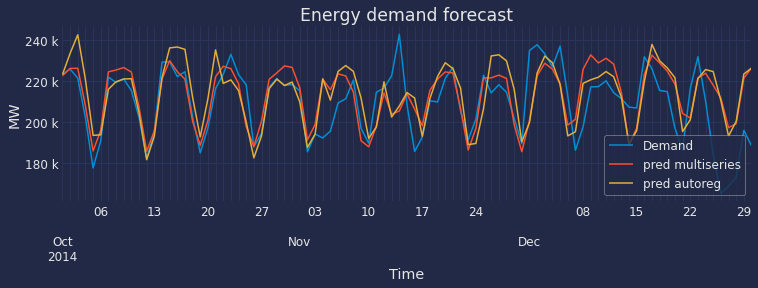

In [180]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(11, 3))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Demand')
predictions_multi.columns = ['pred multiseries']
predictions_multi.plot(ax=ax)
predictions_autoreg.columns = ['pred autoreg']
predictions_autoreg.plot(ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('MW')
ax.set_title('Energy demand forecast')
ax.legend();

### MultiSeries Demand/T

In [6]:
series_cols = ['Demand', 'Temperature']

In [39]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LGBMRegressor(n_estimators=3, max_depth=5, random_state=123,
                                                   max_features=4),
                 lags = 2
             )

forecaster

ForecasterAutoregMultiSeries 
Regressor: RandomForestRegressor(max_depth=5, max_features=4, n_estimators=3,
                      random_state=123) 
Lags: [1 2] 
Window size: 2 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 4, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-27 20:45:26 
Last fit date: None 
Skforecast version: 0.5.dev1 

In [40]:
forecaster.fit(series = data[series_cols])

In [45]:
from sklearn import tree

text_representation = tree.export_text(forecaster.regressor.estimators_[1])
print(text_representation)

|--- feature_0 <= 84416.72
|   |--- feature_0 <= 14.71
|   |   |--- feature_0 <= 12.59
|   |   |   |--- feature_0 <= 9.38
|   |   |   |   |--- feature_1 <= 11.22
|   |   |   |   |   |--- value: [9.14]
|   |   |   |   |--- feature_1 >  11.22
|   |   |   |   |   |--- value: [10.76]
|   |   |   |--- feature_0 >  9.38
|   |   |   |   |--- feature_1 <= 7.98
|   |   |   |   |   |--- value: [13.36]
|   |   |   |   |--- feature_1 >  7.98
|   |   |   |   |   |--- value: [11.53]
|   |   |--- feature_0 >  12.59
|   |   |   |--- feature_0 <= 13.98
|   |   |   |   |--- feature_0 <= 12.73
|   |   |   |   |   |--- value: [14.71]
|   |   |   |   |--- feature_0 >  12.73
|   |   |   |   |   |--- value: [13.43]
|   |   |   |--- feature_0 >  13.98
|   |   |   |   |--- feature_0 <= 14.07
|   |   |   |   |   |--- value: [18.77]
|   |   |   |   |--- feature_0 >  14.07
|   |   |   |   |   |--- value: [15.16]
|   |--- feature_0 >  14.71
|   |   |--- feature_0 <= 19.82
|   |   |   |--- feature_0 <= 16.96
|   | 

In [42]:
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.668978
1,lag_2,0.001975
2,Demand,0.329046
3,Temperature,0.000000


#### Grid search

In [9]:
# Grid search of hyper-parameters and lags
# ==============================================================================
# Regressor hyper-parameters
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 10, 15],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [7]

results_grid = grid_search_forecaster_multiseries(
                            forecaster         = forecaster,
                            series             = data.loc[:end_validation, series_cols],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = 7,
                            levels_list        = ['Demand', 'Temperature'],
                            levels_weights     = None,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(data_train)),
                            return_best        = True,
                            verbose            = False
                    )

Number of models compared: 48.


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [05:26<00:00, 326.83s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 188500037.24054286
  Levels: ['Demand', 'Temperature'] 
  Levels weights: {'Demand': 0.5, 'Temperature': 0.5} 



In [11]:
results_grid

,levels,lags,params,metric,learning_rate,max_depth,n_estimators
2,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.885000e+08,0.01,3.0,1000.0
12,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1.915186e+08,0.10,3.0,100.0
1,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",2.041682e+08,0.01,3.0,500.0
10,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 15, 'n_es...",2.076602e+08,0.01,15.0,500.0
7,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",2.077943e+08,0.01,10.0,500.0
4,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",2.089938e+08,0.01,5.0,500.0
5,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",2.230010e+08,0.01,5.0,1000.0
18,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2.239466e+08,0.10,10.0,100.0
15,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2.248837e+08,0.10,5.0,100.0
11,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 15, 'n_es...",2.250625e+08,0.01,15.0,1000.0


In [21]:
# Grid search of hyper-parameters and lags
# ==============================================================================
# Regressor hyper-parameters
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5],
    'learning_rate': [0.01]
}

# Lags used as predictors
lags_grid = [7]

results_grid = grid_search_forecaster_multiseries(
                            forecaster         = forecaster,
                            series             = data.loc[:end_validation, series_cols],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = 7,
                            levels_list        = ['Demand', 'Temperature'],
                            levels_weights     = None,
                            refit              = True,
                            metric             = 'mean_absolute_percentage_error',
                            initial_train_size = int(len(data_train)),
                            return_best        = False,
                            verbose            = False
               )

4 models compared for 2 level(s). Number of iterations: 8.
Level weights for metric evaluation: {'Demand': 0.5, 'Temperature': 0.5}


loop lags_grid:   0%|                                               | 0/1 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [18]:
results_grid

,levels,lags,params,metric,learning_rate,max_depth,n_estimators
3,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",38.258951,0.01,5.0,1000.0
1,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",49.780039,0.01,3.0,1000.0
2,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",63.131969,0.01,5.0,500.0
0,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",75.028418,0.01,3.0,500.0


In [19]:
print(results_grid['params'][0])

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


#### Backtesting

In [ ]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(learning_rate=0.1,
                                          max_depth=3,
                                          n_estimators=100),
                lags = 7
             )

In [ ]:
# Backtesting
# ==============================================================================
metric, predictions_multi = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = data[series_cols],
                                    level      = 'Demand',
                                    initial_train_size = len(data_train) + len(data_val),
                                    fixed_train_size   = True,
                                    steps      = 7,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = False
                               )

print(f"Backtest error: {metric}")
predictions_multi.head(4)

In [ ]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(11, 3))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Demand')
predictions_multi.columns = ['pred multiseries']
predictions_multi.plot(ax=ax)
predictions_autoreg.columns = ['pred autoreg']
predictions_autoreg.plot(ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('MW')
ax.set_title('Energy demand forecast')
ax.legend();

### Multiseries Scaler

In [28]:
series_cols = ['Demand', 'Temperature']
data.head(3)

,Demand,Temperature,Holiday
Time,,,
2012-01-01,82531.745918,21.047727,True
2012-01-02,227778.257304,26.578125,True
2012-01-03,275490.988882,31.751042,True


In [39]:
# Transform
# ==============================================================================
scaler = StandardScaler()
data_sc = pd.DataFrame(scaler.fit_transform(data[series_cols]), 
                       columns = scaler.get_feature_names_out(),
                       index = data.index)
data_sc.head(3)

,Demand,Temperature
Time,,
2012-01-01,-5.615668,0.975884
2012-01-02,0.154938,2.104100
2012-01-03,2.050552,3.159389


In [41]:
# Inverse Transform
# ==============================================================================
pd.DataFrame(scaler.inverse_transform(data_sc), 
             columns = scaler.get_feature_names_out(),
             index = data.index).head(3)

,Demand,Temperature
Time,,
2012-01-01,82531.745918,21.047727
2012-01-02,227778.257304,26.578125
2012-01-03,275490.988882,31.751042


In [44]:
# Split data into train-val-test
# ==============================================================================
data_sc = data_sc.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-9-30 23:59:00'
data_train = data_sc.loc[: end_train, :].copy()
data_val   = data_sc.loc[end_train:end_validation, :].copy()
data_test  = data_sc.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Validation dates : 2014-01-01 00:00:00 --- 2014-09-30 00:00:00  (n=273)
Test dates       : 2014-10-01 00:00:00 --- 2014-12-30 00:00:00  (n=91)


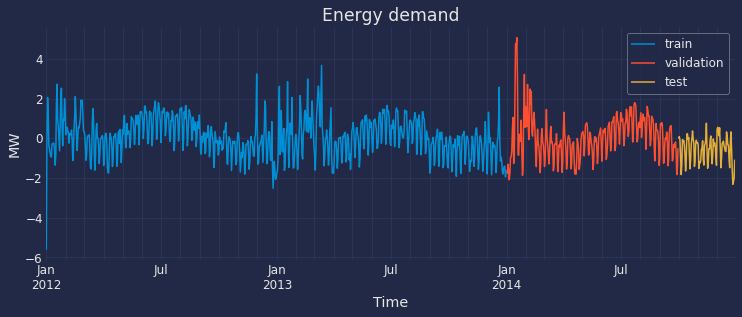

In [51]:
# Plot time serie partition
# ==============================================================================
fig, ax=plt.subplots(figsize=(11, 4))
data_train['Demand'].plot(label='train', ax=ax)
data_val['Demand'].plot(label='validation', ax=ax)
data_test['Demand'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
# ax.set_ylim(bottom=160_000)
ax.set_ylabel('MW')
ax.set_title('Energy demand')
ax.legend();

In [42]:
# Create forecaster
# ==============================================================================
forecaster_no_sc = ForecasterAutoregMultiSeries(
                     regressor = LGBMRegressor(),
                     lags = 7
                   )

forecaster_sc = ForecasterAutoregMultiSeries(
                    regressor = LGBMRegressor(),
                    lags = 7
                )

#### Grid search

In [52]:
# Grid search of hyper-parameters and lags
# ==============================================================================
# Regressor hyper-parameters
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [7]

results_grid = grid_search_forecaster_multiseries(
                            forecaster         = forecaster_no_sc,
                            series             = data.loc[:end_validation, series_cols],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = 7,
                            levels_list        = ['Demand', 'Temperature'],
                            levels_weights     = None,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(data_train)),
                            return_best        = True,
                            verbose            = False
                    )

12 models compared for 2 level(s). Number of iterations: 24.
Level weights for metric evaluation: {'Demand': 0.5, 'Temperature': 0.5}


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [02:53<00:00, 173.01s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
  Backtesting metric: 188500037.24054286
  Levels: ['Demand', 'Temperature'] 
  Levels weights: {'Demand': 0.5, 'Temperature': 0.5} 



In [53]:
results_grid

,levels,lags,params,metric,learning_rate,max_depth,n_estimators
1,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.885000e+08,0.01,3.0,1000.0
0,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",2.041682e+08,0.01,3.0,500.0
4,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",2.077943e+08,0.01,10.0,500.0
2,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",2.089938e+08,0.01,5.0,500.0
3,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",2.230010e+08,0.01,5.0,1000.0
5,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",2.255489e+08,0.01,10.0,1000.0
6,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",2.575379e+08,0.10,3.0,500.0
7,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",2.765634e+08,0.10,3.0,1000.0
8,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2.784376e+08,0.10,5.0,500.0
10,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",2.867010e+08,0.10,10.0,500.0


In [54]:
# Grid search of hyper-parameters and lags
# ==============================================================================
# Regressor hyper-parameters
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [7]

results_grid_sc = grid_search_forecaster_multiseries(
                            forecaster         = forecaster_sc,
                            series             = data_sc.loc[:end_validation, series_cols],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = 7,
                            levels_list        = ['Demand', 'Temperature'],
                            levels_weights     = None,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(data_train)),
                            return_best        = True,
                            verbose            = False
                    )

12 models compared for 2 level(s). Number of iterations: 24.
Level weights for metric evaluation: {'Demand': 0.5, 'Temperature': 0.5}


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [03:13<00:00, 193.80s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.5958159954039451
  Levels: ['Demand', 'Temperature'] 
  Levels weights: {'Demand': 0.5, 'Temperature': 0.5} 



In [55]:
results_grid_sc

,levels,lags,params,metric,learning_rate,max_depth,n_estimators
0,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.595816,0.01,3.0,500.0
1,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.600055,0.01,3.0,1000.0
2,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.613695,0.01,5.0,500.0
4,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.616407,0.01,10.0,500.0
3,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.632749,0.01,5.0,1000.0
5,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.642485,0.01,10.0,1000.0
6,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.711823,0.10,3.0,500.0
8,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.735313,0.10,5.0,500.0
10,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.811411,0.10,10.0,500.0
7,"[Demand, Temperature]","[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.822267,0.10,3.0,1000.0


#### Backtesting

In [89]:
# Hyperparameters forecaster
# ==============================================================================
forecaster_no_sc = ForecasterAutoregMultiSeries(
                     regressor = LGBMRegressor(learning_rate=0.01,
                                               max_depth=3,
                                               n_estimators=1000),
                     lags = 7
                   )

forecaster_sc = ForecasterAutoregMultiSeries(
                    regressor = LGBMRegressor(learning_rate=0.01,
                                              max_depth=3,
                                              n_estimators=1000),
                    lags = 7
                )

In [90]:
# Backtesting
# ==============================================================================
metric_no_sc, predictions_multi_no_sc = backtesting_forecaster_multiseries(
                                            forecaster = forecaster_no_sc,
                                            series     = data[series_cols],
                                            level      = 'Demand',
                                            initial_train_size = len(data_train) + len(data_val),
                                            fixed_train_size   = True,
                                            steps      = 7,
                                            metric     = 'mean_squared_error',
                                            refit      = True,
                                            verbose    = False
                                        )

print(f"Backtest error: {metric_no_sc}")
predictions_multi_no_sc.head(4)

Backtest error: 208498393.46579215


,pred
2014-10-01,221874.966472
2014-10-02,224947.467891
2014-10-03,226281.045311
2014-10-04,208776.077070


In [91]:
# Backtesting error with series no scaler
# ==============================================================================
mean_squared_error(y_true=data.loc[end_validation:, 'Demand'],
                   y_pred=predictions_multi_no_sc)

208498393.46579215

In [92]:
# Backtesting
# ==============================================================================
metric_sc, predictions_multi_sc = backtesting_forecaster_multiseries(
                                        forecaster = forecaster_sc,
                                        series     = data_sc[series_cols],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train) + len(data_val),
                                        fixed_train_size   = True,
                                        steps      = 7,
                                        metric     = 'mean_squared_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error: {metric_sc}")
predictions_multi_sc.head(4)

Backtest error: 0.29870549206626656


,pred
2014-10-01,-0.002599
2014-10-02,0.193708
2014-10-03,0.299828
2014-10-04,-0.366262


In [97]:
# Create naive column to apply scaler
# ==============================================================================
predictions_multi_sc['naive'] = list(range(0, len(predictions_multi_sc)))
display(predictions_multi_sc.head(2))

# Inverse_transform
# ==============================================================================
y_pred_values = scaler.inverse_transform(predictions_multi_sc)
y_pred_values[:3]

,pred,naive
2014-10-01,-0.002599,0
2014-10-02,0.193708,1


array([[2.23813037e+05, 1.62640485e+01],
       [2.28754100e+05, 2.11659430e+01],
       [2.31425152e+05, 2.60678375e+01]])

In [95]:
# Backtesting error with series scaler
# ==============================================================================
y_pred = pd.Series(y_pred_values[:,0], index=predictions_multi_sc.index, name='sc')

mean_squared_error(y_true=data.loc[end_validation:, 'Demand'],
                   y_pred=y_pred)

189239494.20984533

In [ ]:
autoreg   = 209046702.5552355
sin_escar = 208498393.46579215
escalando = 189239494.20984533

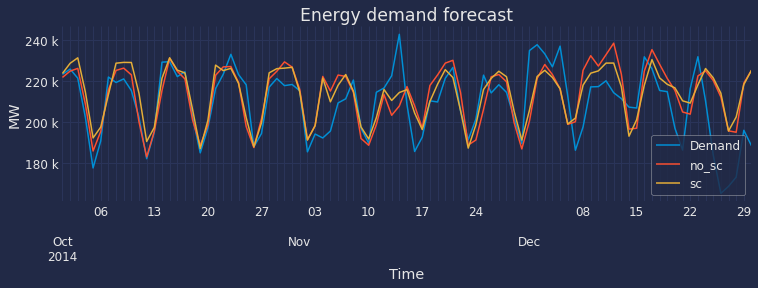

In [96]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(11, 3))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Demand')
predictions_multi_no_sc.columns = ['no_sc']
predictions_multi_no_sc.plot(ax=ax)
y_pred.plot(ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('MW')
ax.set_title('Energy demand forecast')
ax.legend();

#### Tree exploration

In [77]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = RandomForestRegressor(n_estimators=3, max_depth=5, random_state=123,
                                                   max_features=4),
                 lags = 2
             )

forecaster.fit(series = data_sc[series_cols])

In [80]:
from sklearn import tree

text_representation = tree.export_text(forecaster.regressor.estimators_[0])
print(text_representation)

|--- feature_0 <= 0.03
|   |--- feature_0 <= -0.53
|   |   |--- feature_0 <= -1.37
|   |   |   |--- feature_0 <= -1.93
|   |   |   |   |--- feature_0 <= -2.04
|   |   |   |   |   |--- value: [-1.93]
|   |   |   |   |--- feature_0 >  -2.04
|   |   |   |   |   |--- value: [-1.70]
|   |   |   |--- feature_0 >  -1.93
|   |   |   |   |--- feature_1 <= 0.66
|   |   |   |   |   |--- value: [-1.19]
|   |   |   |   |--- feature_1 >  0.66
|   |   |   |   |   |--- value: [-2.52]
|   |   |--- feature_0 >  -1.37
|   |   |   |--- feature_1 <= -1.26
|   |   |   |   |--- feature_3 <= 0.50
|   |   |   |   |   |--- value: [-0.01]
|   |   |   |   |--- feature_3 >  0.50
|   |   |   |   |   |--- value: [-0.92]
|   |   |   |--- feature_1 >  -1.26
|   |   |   |   |--- feature_1 <= -0.48
|   |   |   |   |   |--- value: [-0.72]
|   |   |   |   |--- feature_1 >  -0.48
|   |   |   |   |   |--- value: [-1.01]
|   |--- feature_0 >  -0.53
|   |   |--- feature_1 <= -0.48
|   |   |   |--- feature_2 <= 0.50
|   |   | 